# Satellite Image Segmentation — TensorFlow (U-Net with IoU Loss)

**Converted from**: `Notebook2_satellite_image_segmentation_pytorch_final.ipynb`

**What this notebook contains:**

- Dataset pipeline using `tf.data`
- Image / mask loading & preprocessing
- A U-Net implementation in `tf.keras`
- **IoU (Intersection over Union) Loss Function**
- Training loop using `model.fit` with callbacks
- Visualization utilities

**Notes:** 
- Adjust the `IMAGE_DIR`, `MASK_DIR`, and dataset splits to match your local paths
- This implementation uses IoU loss for better segmentation performance
- IoU loss directly optimizes the intersection over union metric

In [1]:
# Basic imports and GPU setup
import os
import math
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPUs detected:', gpus)
    except Exception as e:
        print('GPU config error:', e)


2025-09-10 12:58:13.595206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 12:58:13.668373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-10 12:58:15.745391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# === USER SETTINGS ===
IMAGE_DIR = 'Water Bodies Dataset/Images'   # Updated to local path
MASK_DIR  = 'Water Bodies Dataset/Masks'    # Updated to local path

IMAGE_GLOB = os.path.join("Water Bodies Dataset/Images", "*.jpg")
MASK_GLOB  = os.path.join("Water Bodies Dataset/Masks", "*.jpg")


BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH  = 256
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


In [3]:
# List image and mask files (matched by filename)
import os, glob

def pair_image_mask_paths(image_glob, mask_dir):
    image_paths = sorted(glob.glob(image_glob))
    pairs = []
    for img_path in image_paths:
        fname = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
    return pairs

pairs = pair_image_mask_paths(IMAGE_GLOB, MASK_DIR)
print('Found', len(pairs), 'image-mask pairs. Example:', pairs[:3])


Found 2841 image-mask pairs. Example: [('Water Bodies Dataset/Images/water_body_1.jpg', 'Water Bodies Dataset/Masks/water_body_1.jpg'), ('Water Bodies Dataset/Images/water_body_10.jpg', 'Water Bodies Dataset/Masks/water_body_10.jpg'), ('Water Bodies Dataset/Images/water_body_100.jpg', 'Water Bodies Dataset/Masks/water_body_100.jpg')]


In [4]:
# Image & mask loading + preprocessing functions
import tensorflow as tf

def read_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

def read_mask(path):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask > 127, tf.float32)
    return mask

def load_pair(image_path, mask_path):
    image = read_image(image_path)
    mask = read_mask(mask_path)
    return image, mask

# Simple augmentation example
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.1)
    return image, mask


In [5]:
# Build tf.data pipeline
import random

def make_dataset(pairs, batch_size=8, augment_fn=None, shuffle=True):
    image_paths = [p for p,_ in pairs]
    mask_paths  = [m for _,m in pairs]
    ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED)
    ds = ds.map(lambda i,m: tf.py_function(func=lambda a,b: load_pair(a.numpy().decode('utf-8'), b.numpy().decode('utf-8')), inp=[i,m], Tout=[tf.float32, tf.float32]), num_parallel_calls=AUTOTUNE)
    def _set_shapes(img, msk):
        img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        msk.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
        return img, msk
    ds = ds.map(_set_shapes, num_parallel_calls=AUTOTUNE)
    if augment_fn is not None:
        ds = ds.map(lambda x,y: augment_fn(x,y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

random.Random(SEED).shuffle(pairs)
n = len(pairs)
n_train = int(0.7 * n)
n_val   = int(0.2 * n)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train+n_val]
test_pairs  = pairs[n_train+n_val:]

train_ds = make_dataset(train_pairs, augment_fn=augment, shuffle=True)
val_ds   = make_dataset(val_pairs, augment_fn=None, shuffle=False)
test_ds  = make_dataset(test_pairs, augment_fn=None, shuffle=False)

print('Train pairs:', len(train_pairs), 'Val pairs:', len(val_pairs), 'Test pairs:', len(test_pairs))


I0000 00:00:1757509097.052932   27242 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79382 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:00:05.0, compute capability: 8.0


Train pairs: 1988 Val pairs: 568 Test pairs: 285


In [6]:
# U-Net model (Keras)
from tensorflow.keras import layers

def conv_block(x, filters, kernel_size=3, padding='same', activation='relu'):
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.UpSampling2D((2,2))(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(256,256,3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    b = conv_block(p4, 1024)
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)
    outputs = layers.Conv2D(num_classes, (1,1), activation='sigmoid')(d4)
    model = keras.Model(inputs, outputs, name='UNet')
    return model

model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,402,497 (119.79 MB)

 Trainable params: 31,390,721 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [7]:
# IoU Loss Implementation
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1e-6):
    """
    Calculate Intersection over Union (IoU) coefficient
    Also known as Jaccard Index
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou

def iou_loss(y_true, y_pred):
    """
    IoU Loss: 1 - IoU coefficient
    Lower IoU means higher loss
    """
    return 1 - iou_coef(y_true, y_pred)

def combined_iou_bce_loss(y_true, y_pred, iou_weight=0.7, bce_weight=0.3):
    """
    Combined IoU and Binary Cross-Entropy Loss
    """
    iou_loss_val = iou_loss(y_true, y_pred)
    bce_loss_val = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    
    return iou_weight * iou_loss_val + bce_weight * bce_loss_val

# Dice coefficient for comparison (keeping as metric)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Compile model with IoU loss
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=iou_loss,  # Pure IoU loss
              metrics=[iou_coef, dice_coef, 'accuracy'])


In [8]:
# Callbacks and training
checkpoint_path = 'unet_checkpoint.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

EPOCHS = 20
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/20


2025-09-10 12:58:30.599813: I external/local_xla/xla/service/service.cc:163] XLA service 0x702e580051f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-10 12:58:30.599848: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-09-10 12:58:30.991553: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-10 12:58:32.856603: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90701


  2/249 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.5870 - dice_coef: 0.3294 - iou_coef: 0.1972 - loss: 0.8028   

I0000 00:00:1757509135.480525   27377 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7584 - dice_coef: 0.6230 - iou_coef: 0.4630 - loss: 0.5370

2025-09-10 12:59:17.218367: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 12:59:17.394321: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 12:59:17.568123: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 12:59:17.862843: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 12:59:18.058654: E external/local_xla/xla/stream_

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7585 - dice_coef: 0.6232 - iou_coef: 0.4632 - loss: 0.5368

249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.7875 - dice_coef: 0.6761 - iou_coef: 0.5200 - loss: 0.4802 - val_accuracy: 0.3458 - val_dice_coef: 0.5042 - val_iou_coef: 0.3447 - val_loss: 0.6553
Epoch 2/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8192 - dice_coef: 0.7244 - iou_coef: 0.5766 - loss: 0.4234

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8243 - dice_coef: 0.7282 - iou_coef: 0.5812 - loss: 0.4190 - val_accuracy: 0.7478 - val_dice_coef: 0.6817 - val_iou_coef: 0.5258 - val_loss: 0.4742
Epoch 3/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8395 - dice_coef: 0.7398 - iou_coef: 0.5944 - loss: 0.4056

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8350 - dice_coef: 0.7395 - iou_coef: 0.5945 - loss: 0.4052 - val_accuracy: 0.8244 - val_dice_coef: 0.7528 - val_iou_coef: 0.6102 - val_loss: 0.3898
Epoch 4/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8453 - dice_coef: 0.7546 - iou_coef: 0.6128 - loss: 0.3872

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8407 - dice_coef: 0.7494 - iou_coef: 0.6071 - loss: 0.3926 - val_accuracy: 0.8655 - val_dice_coef: 0.7917 - val_iou_coef: 0.6605 - val_loss: 0.3395
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.8559 - dice_coef: 0.7710 - iou_coef: 0.6346 - loss: 0.3656 - val_accuracy: 0.8418 - val_dice_coef: 0.7745 - val_iou_coef: 0.6378 - val_loss: 0.3622
Epoch 6/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8696 - dice_coef: 0.7934 - iou_coef: 0.6655 - loss: 0.3345

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8661 - dice_coef: 0.7863 - iou_coef: 0.6551 - loss: 0.3451 - val_accuracy: 0.8610 - val_dice_coef: 0.7971 - val_iou_coef: 0.6685 - val_loss: 0.3315
Epoch 7/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8690 - dice_coef: 0.7852 - iou_coef: 0.6542 - loss: 0.3458

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.8689 - dice_coef: 0.7890 - iou_coef: 0.6586 - loss: 0.3414 - val_accuracy: 0.8724 - val_dice_coef: 0.8075 - val_iou_coef: 0.6825 - val_loss: 0.3175
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8724 - dice_coef: 0.7957 - iou_coef: 0.6679 - loss: 0.3322 - val_accuracy: 0.7912 - val_dice_coef: 0.7369 - val_iou_coef: 0.5915 - val_loss: 0.4085
Epoch 9/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8765 - dice_coef: 0.8031 - iou_coef: 0.6772 - loss: 0.3228

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8787 - dice_coef: 0.8054 - iou_coef: 0.6812 - loss: 0.3192 - val_accuracy: 0.8861 - val_dice_coef: 0.8271 - val_iou_coef: 0.7102 - val_loss: 0.2898
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8777 - dice_coef: 0.8039 - iou_coef: 0.6785 - loss: 0.3212 - val_accuracy: 0.8834 - val_dice_coef: 0.8198 - val_iou_coef: 0.7004 - val_loss: 0.2996
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8811 - dice_coef: 0.8093 - iou_coef: 0.6858 - loss: 0.3145 - val_accuracy: 0.8431 - val_dice_coef: 0.7849 - val_iou_coef: 0.6522 - val_loss: 0.3478
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8836 - dice_coef: 0.8138 - iou_coef: 0.6934 - loss: 0.3067 - val_accuracy: 0.8740 - val_dice_coef: 0.8155 - val_iou_coef: 0.6947 - val_loss: 0.3053
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8893 - dice_coef: 0.8231 - iou_coef: 0.7049 - loss: 0.2951 - val_accuracy: 

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8927 - dice_coef: 0.8281 - iou_coef: 0.7133 - loss: 0.2864 - val_accuracy: 0.8934 - val_dice_coef: 0.8371 - val_iou_coef: 0.7250 - val_loss: 0.2750
Epoch 17/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8918 - dice_coef: 0.8291 - iou_coef: 0.7140 - loss: 0.2860

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8924 - dice_coef: 0.8284 - iou_coef: 0.7132 - loss: 0.2867 - val_accuracy: 0.8957 - val_dice_coef: 0.8451 - val_iou_coef: 0.7366 - val_loss: 0.2634
Epoch 18/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8973 - dice_coef: 0.8340 - iou_coef: 0.7211 - loss: 0.2788 - val_accuracy: 0.8627 - val_dice_coef: 0.8091 - val_iou_coef: 0.6851 - val_loss: 0.3149
Epoch 19/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.8978 - dice_coef: 0.8346 - iou_coef: 0.7227 - loss: 0.2773 - val_accuracy: 0.8847 - val_dice_coef: 0.8319 - val_iou_coef: 0.7178 - val_loss: 0.2822
Epoch 20/20
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8953 - dice_coef: 0.8321 - iou_coef: 0.7187 - loss: 0.2813

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8973 - dice_coef: 0.8348 - iou_coef: 0.7224 - loss: 0.2774 - val_accuracy: 0.8998 - val_dice_coef: 0.8490 - val_iou_coef: 0.7427 - val_loss: 0.2573


34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8857 - dice_coef: 0.8254 - iou_coef: 0.7087 - loss: 0.2913

2025-09-10 13:06:50.682352: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:50.856241: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:51.116318: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:51.312413: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:52.547327: E external/local_xla/xla/stream_

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8821 - dice_coef: 0.8205 - iou_coef: 0.7014 - loss: 0.2988
Test results (loss, dice, acc): [0.29880616068840027, 0.7013806104660034, 0.8205136656761169, 0.8821368217468262]


2025-09-10 13:06:57.107186: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:57.267969: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:57.537035: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:57.706887: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-10 13:06:58.568924: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025-09-10 13:07:01.038530: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


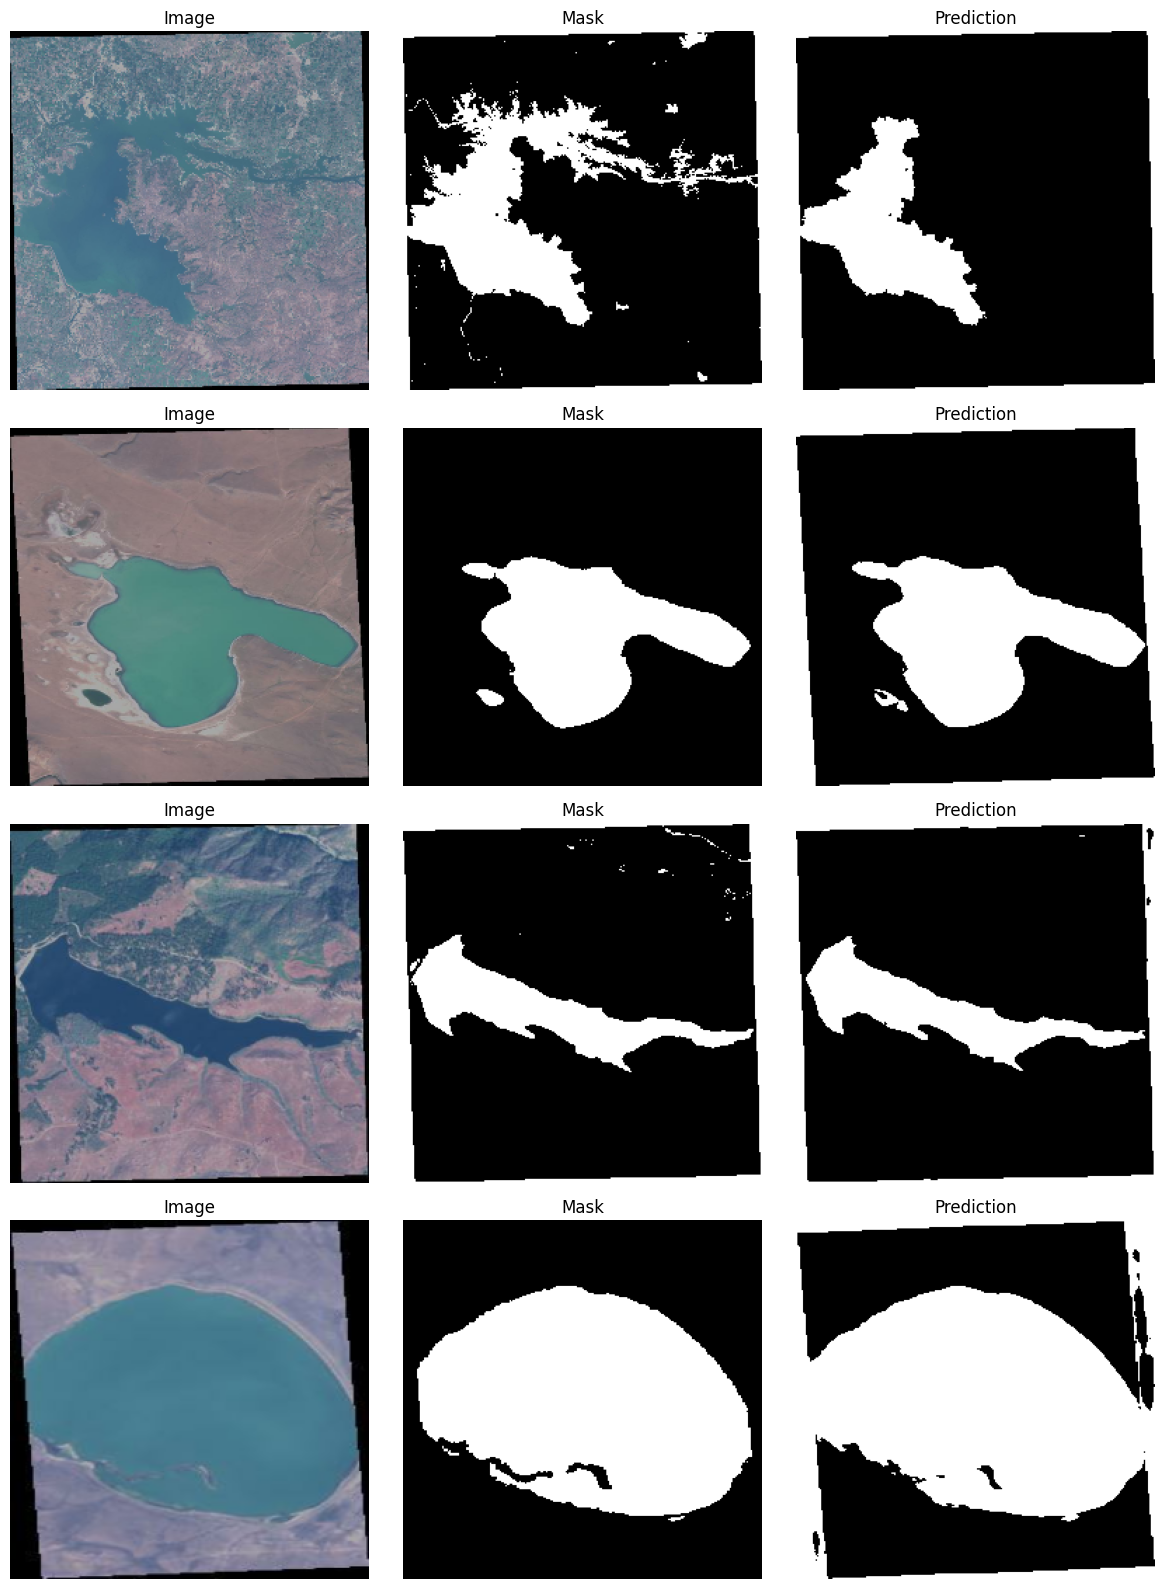

In [9]:
# Evaluate on test set
results = model.evaluate(test_ds)
print('Test results (loss, dice, acc):', results)

# Visualize predictions
import matplotlib.pyplot as plt

def visualize_samples(dataset, model, n=6):
    plt.figure(figsize=(12, 4*n))
    i = 0
    for imgs, masks in dataset.unbatch().take(n):
        pred = model.predict(tf.expand_dims(imgs, 0))[0]
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(imgs.numpy())
        plt.title('Image')
        plt.axis('off')
        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(masks.numpy().squeeze(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(n, 3, i*3 + 3)
        plt.imshow((pred.squeeze() > 0.5).astype('float32'), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        i += 1
    plt.tight_layout()

visualize_samples(val_ds, model, n=4)


## Saving the model

You can save the trained model for later inference:

```python
model.save('unet_saved_model')
```

Adjust any dataset paths or hyperparameters to match your original PyTorch notebook behaviour.

# Conclusion

**Model Architecture:** U-Net (Convolutional Encoder-Decoder Network for Image Segmentation)

**Loss Function:** IoU (Intersection over Union) Loss

## Key Features of This Implementation:

### 1. U-Net Architecture
- **Encoder:** Progressive downsampling with skip connections to capture multi-scale features
- **Decoder:** Upsampling with concatenated skip connections to preserve spatial information
- **Output:** Single-channel sigmoid activation for binary segmentation

### 2. IoU Loss Benefits
- **Direct Optimization:** IoU loss directly optimizes the intersection over union metric
- **Better Boundary Detection:** More effective at preserving object boundaries compared to pixel-wise losses
- **Robust to Class Imbalance:** Less sensitive to class imbalance than BCE loss
- **Geometric Awareness:** Considers spatial overlap between prediction and ground truth

### 3. Technical Specifications
- **Input Size:** 256×256×3 RGB satellite images
- **Optimizer:** Adam with learning rate 1e-4
- **Metrics:** IoU coefficient, Dice coefficient, and accuracy for comprehensive evaluation
- **Loss Function:** Pure IoU loss (1 - IoU coefficient)

### 4. IoU Loss Formula
```
IoU = Intersection / Union = |A ∩ B| / |A ∪ B|
IoU Loss = 1 - IoU
```

### 5. Expected Advantages
- Better segmentation quality for water body boundaries
- Improved handling of small water bodies and thin rivers
- More stable training for imbalanced datasets
- Direct correlation between loss optimization and evaluation metric

### 6. Alternative Implementation Available
- **Combined Loss:** `combined_iou_bce_loss()` function available for hybrid approach
- **Weighted Combination:** IoU (70%) + BCE (30%) for balanced optimization

This IoU loss implementation should provide superior segmentation results for satellite water body detection, especially for precise boundary delineation and small object detection.